In [856]:
# Import libraries
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format

# Import dataset
df = pd.read_csv('./Phishing_Email.csv')
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [857]:
df.drop(df.columns[0], axis=1, inplace=True)

In [858]:
df.shape

(18650, 2)

In [859]:
df.isnull().sum()

Email Text    16
Email Type     0
dtype: int64

In [860]:
df.dropna(inplace=True)

In [861]:
df.shape

(18634, 2)

In [862]:
df["Email Type"].value_counts()

Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64

<Axes: >

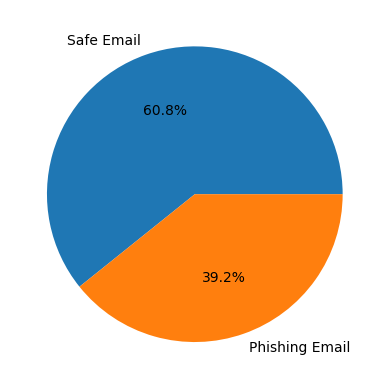

In [863]:
df["Email Type"].value_counts().plot(kind="pie", autopct='%1.1f%%', ylabel='')

<Axes: >

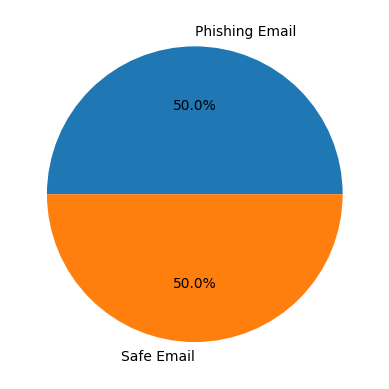

In [864]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop(columns=["Email Type"])
y = df["Email Type"]
texts_under, labels_under = RandomUnderSampler(random_state=100).fit_resample(X, y)
labels_under.value_counts().plot(kind="pie", autopct='%1.1f%%', ylabel='')

In [865]:
texts_under

,Email Text
3,\nHello I am your hot lil horny toy.\n I am...
4,software at incredibly low prices ( 86 % lower...
7,"entourage , stockmogul newsletter ralph velez ..."
8,"we owe you lots of money dear applicant , afte..."
10,make her beg you to give it to her everynight ...
...,...
13161,thanks thanks to all of the many people who se...
14405,"At 12:32 PM 12/28/00 -0600, Adam Rifkin wrote:..."
14027,"benefits for terminated employees hi all , i j..."
17259,re : question on office space in the new build...


In [866]:
texts_under["Word Count"] = texts_under["Email Text"].apply(lambda texto: len(texto.split(" ")))
texts_under["Word Count"].describe()

count              14,624.00
mean                  341.53
std                   700.65
min                     1.00
25%                    72.00
50%                   158.00
75%                   355.00
max                18,971.00
Name: Word Count, dtype: float64

Text(0, 0.5, 'Count')

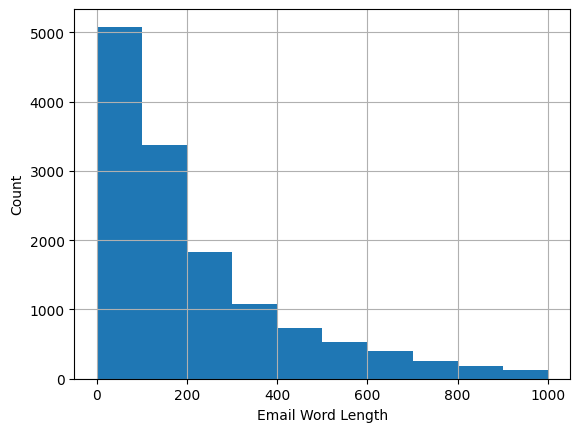

In [867]:
ax = texts_under["Word Count"].hist(range=[0, 1000])
ax.set_xlabel('Email Word Length')
ax.set_ylabel('Count')

In [868]:
from sklearn.preprocessing import LabelEncoder

encoded_labels = LabelEncoder().fit_transform(labels_under)
encoded_labels

array([0, 0, 0, ..., 1, 1, 1])

In [869]:
import re

def parse_sentence(text: str):
    clean_text = ""
    for word in text.lower().split(" "):
        if word.startswith('@') and len(word) > 1:
            word = 'user'
        elif word.startswith('http'):
            word = 'http'
        clean_text += word + " "
    clean_text = re.sub(r'["#$%&\'()*+,\-./:;<=>@[\]^_`{|}~―]', '', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text)
    return clean_text[:-1]

texts_clean = texts_under["Email Text"].apply(lambda texto: parse_sentence(texto))
texts_clean.values

array([' hello i am your hot lil horny toy i am the one you dream about i am a very open minded person love to talk about and any subject fantasy is my way of life ultimate in sex play ummmmmmmmmmmmmm i am wet and ready for you it is not your looks but your imagination that matters most with my sexy voice i can make your dream come true hurry up! call me let me cummmmm for you tollfree 1877451teen 18774518336for phone billing 19009932582 signup for your own free personalized email at mailcom httpwwwmailcom?srsignup',
       'software at incredibly low prices 86 lower drapery seventeen term represent any sing feet wild break able build tail send subtract represent job cow student inch gave let still warm family draw land book glass plan include sentence is hat silent nothing order wild famous long their inch such saw person save face especially sentence science certain cry does two depend yes written carry',
       'entourage stockmogul newsletter ralph velez genex pharmaceutical inc ot

In [870]:
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

#nltk.download('punkt')  # Download the tokenizer models if not already downloaded
#tokenized_corpus = [word_tokenize(text.lower()) for text in texts_clean.values] # Lowercasing for consistency
#skipgram_model = Word2Vec(sentences=tokenized_corpus,
#                          vector_size=128,  # Dimensionality of the word vectors
#                          window=5,         # Maximum distance between the current and predicted word within a sentence
#                          sg=1,             # Skip-Gram model (1 for Skip-Gram, 0 for CBOW)
#                          min_count=1,      # Ignores all words with a total frequency lower than this
#                          workers=-1)        # Number of CPU cores to use for training the model
## Training
#skipgram_model.train([tokenized_corpus], total_examples=1, epochs=10)
#skipgram_model.save("skipgram_model.model")
loaded_model = Word2Vec.load("Models/word2vec/skipgram_model.model")

In [871]:
import numpy as np 
import torch

new_vocab_size = len(loaded_model.wv)
new_embedding_dim = loaded_model.vector_size

# Create an embedding matrix
embedding_matrix = np.zeros((new_vocab_size, new_embedding_dim))
word2index = {word: idx for idx, word in enumerate(loaded_model.wv.index_to_key)}

for word, idx in word2index.items():
    embedding_matrix[idx] = loaded_model.wv[word]

# Convert embedding matrix to a tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32, requires_grad=True)

In [872]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):
    def __init__(self, embedding_matrix, num_encoder_layers=2, nhead=4, dropout=0.3):
        super(TransformerModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        encoder_layer = TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, batch_first=True, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x.squeeze(1)
    
    def get_embedding(self, x):
        return self.embedding(x)
    
    def adv_forward(self, x):
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x.squeeze(1)

In [873]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split

class TextDataset(Dataset):
    def __init__(self, texts, labels, word2index):
        self.texts = texts
        self.labels = labels
        self.word2index = word2index
        self.max_len = 1024

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx].split()
        label = self.labels[idx]
        indices = [self.word2index.get(word, 0) for word in text]  # Use 0 for unknown words
        # Pad or truncate the sequence to max_len
        padded_indices = indices
        if len(indices) < self.max_len:
            padded_indices = indices + [0] * (self.max_len - len(indices))
        padded_indices = padded_indices[:self.max_len]
        return torch.tensor(padded_indices, dtype=torch.long), torch.tensor(label, dtype=torch.float32)

# Split the dataset into training and validation sets
dataset = TextDataset(texts_clean.values, encoded_labels, word2index)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

torch.manual_seed(100)

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

for seed in range(5):
    model = TransformerModel(embedding_matrix)

    # Load model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f'\nIteration: {seed}')
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min' , factor=0.1, patience=4)

    # Training loop
    num_epochs = 20

    # Define early stopping parameters
    early_stopping_patience = 8
    best_val_loss = float('inf')
    patience_counter = 0

    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, label in train_loader:
            inputs, label = inputs.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, label in val_loader:
                inputs, label = inputs.to(device), label.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, label)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), f'Models/best_custom_model_{seed}.pt')
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break


Iteration: 0
Epoch 1/20, Train Loss: 0.4967, Val Loss: 0.1448
Epoch 2/20, Train Loss: 0.1181, Val Loss: 0.1028
Epoch 3/20, Train Loss: 0.0607, Val Loss: 0.1134
Epoch 4/20, Train Loss: 0.0421, Val Loss: 0.1486


KeyboardInterrupt: 

In [ ]:
precision_list = []
recall_list = []
f1_list = []

for seed in range(5):
    # Load the best model
    model.load_state_dict(torch.load(f'Models/best_custom_model_{seed}.pt'))

    # Evaluation on test set
    from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc

    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Print metrics
    print(f'\nIteration: {seed}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

In [ ]:
print('Overall:')
print(f'Average Precision: {np.mean(precision_list)}')
print(f'Average Recall: {np.mean(recall_list)}')
print(f'Average F1: {np.mean(f1_list)}')

In [ ]:
# Plot confusion matrix
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [874]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [878]:
for seed in range(5):
    model = TransformerModel(embedding_matrix)

    # Load model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f'\nIteration: {seed}')
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min' , factor=0.1, patience=4)

    # Training loop
    num_epochs = 20
    epsilon = 0.1

    # Define early stopping parameters
    early_stopping_patience = 8
    best_val_loss = float('inf')
    patience_counter = 0

    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, label in train_loader:
            inputs, label = inputs.to(device), label.to(device)
            embedding = model.get_embedding(inputs)
            embedding.retain_grad()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            # Adversarial training
            perturbed_inputs = embedding + epsilon * embedding.grad.sign()
            perturbed_outputs = model.adv_forward(perturbed_inputs)
            loss_adv = criterion(perturbed_outputs, label)

            loss_adv.backward()
            optimizer.step()

            train_loss += (loss.item() + loss_adv.item()) * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, label in val_loader:
                inputs, label = inputs.to(device), label.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, label)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), f'Models/best_custom_model_{seed}.pt')
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break


Iteration: 0


AttributeError: 'NoneType' object has no attribute 'sign'

In [ ]:
precision_list = []
recall_list = []
f1_list = []

for seed in range(5):
    # Load the best model
    model.load_state_dict(torch.load(f'Models/best_adversarial_custom_model_{seed}.pt'))

    # Evaluation on test set
    from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc

    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Print metrics
    print(f'\nIteration: {seed}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

In [ ]:
print('Overall:')
print(f'Average Precision: {np.mean(precision_list)}')
print(f'Average Recall: {np.mean(recall_list)}')
print(f'Average F1: {np.mean(f1_list)}')

In [ ]:
# Plot confusion matrix
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()